## **Checking**

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print(" GPU Not Found, Using CPU!")

GPU Available: Tesla T4


In [ ]:
# Google Drive import
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define dataset path
data_path = "/content/drive/My Drive/ColabNotebooks/Argoverse"

# Check if Train, Validation, and Test folders exist
folders = ["train", "val", "test_obs"]
for folder in folders:
    full_path = os.path.join(data_path, folder)
    if os.path.exists(full_path):
        print(f"{folder} folder found: {full_path}")
    else:
        print(f"{folder} folder not found!")

train folder found: /content/drive/My Drive/ColabNotebooks/Argoverse/train
val folder found: /content/drive/My Drive/ColabNotebooks/Argoverse/val
test_obs folder found: /content/drive/My Drive/ColabNotebooks/Argoverse/test_obs


## **Import Libraries**


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import random

## **Set a fixed random seed**  

In [ ]:
# Set a fixed seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# If using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}")

Random seed set to 42


## **Dataset Class: Combine All CSVs**

In [ ]:
class ArgoverseCSVDataset(Dataset):

    """
    This class reads all CSV files from a directory and generates multiple sub-scenarios from each CSV file using a sliding window approach.
    """

    def __init__(self, data_dir,
                 max_agents=10,
                 history_steps=10,
                 future_steps=6,
                 temporal_T=5,
                 dist_threshold=10.0,
                 stride=None):


        super().__init__()
        self.data_dir = data_dir

        # Collect all CSV files
        self.csv_files = [os.path.join(data_dir, f)
                          for f in os.listdir(data_dir)
                          if f.endswith('.csv')]
        self.csv_files.sort()

        # Model-related parameters
        self.max_agents = max_agents
        self.history_steps = history_steps
        self.future_steps = future_steps
        self.temporal_T = temporal_T
        self.dist_threshold = dist_threshold

        # Default stride is set to cover history + future frames unless specified
        if stride is None:
            self.stride = (self.history_steps + self.future_steps)
        else:
            self.stride = stride

        # Feature dimensions
        self.agent_input_dim = 4 
        self.motif_spatial_dim = 16
        self.motif_temporal_dim = 16
        self.output_dim = 2 # Future trajectory (x, y)

        # List to store all sub-scenarios (samples)
        self.samples = []

        # Process each CSV file to generate sub-scenarios
        for csv_file in self.csv_files:
            self._process_csv(csv_file)

    def _process_csv(self, csv_file):

        """
        Reads a CSV file and generates sub-scenarios using a sliding window approach.
        Each sub-scenario consists of a set of agent features, adjacency relationships, and future trajectory ground truth.
        """

        np.random.seed(SEED)  # Set NumPy seed before random operations
        random.seed(SEED)  # Set Python random seed before random operations

        df = pd.read_csv(csv_file)
        df.sort_values(by=["TIMESTAMP"], inplace=True)
        df.reset_index(drop=True, inplace=True)

        # Get all unique timestamps
        timestamps = df["TIMESTAMP"].unique()
        timestamps.sort()

        total_frames_needed = self.history_steps + self.future_steps
        start_idx = 0

        # Sliding window approach for data segmentation
        while start_idx + total_frames_needed <= len(timestamps):
            window_timestamps = timestamps[start_idx : start_idx + total_frames_needed]
            sub_sample = self._create_subsample(df, window_timestamps)
            if sub_sample is not None:
                self.samples.append(sub_sample)
            start_idx += self.stride

    def _create_subsample(self, df, window_timestamps):

        """
        For a given time window, extracts the data and generates:
          - agent_features, spatial_motif, temporal_motif, adjacency, and ground truth (future)
        """
        np.random.seed(SEED)  # Set NumPy seed before agent selection
        random.seed(SEED)  # Set Python random seed before agent selection

        window_df = df[df["TIMESTAMP"].isin(window_timestamps)].copy()
        window_df.sort_values(by=["TIMESTAMP"], inplace=True)
        track_ids = window_df["TRACK_ID"].unique()

        agent_feats = []
        pos_last_list = []
        temporal_motifs = []
        future_list = []

        # For each agent, if it has at least (history_steps + future_steps) frames, split into history and future. So, iterate over each agent and process its trajectory data.
        for track_id in track_ids:
            df_agent = window_df[window_df["TRACK_ID"] == track_id].sort_values("TIMESTAMP")

            # Ensure the agent has enough frames for both history and future prediction.
            if len(df_agent) < (self.history_steps + self.future_steps):
                continue
            history_df = df_agent.iloc[:self.history_steps] # Past trajectory
            future_df = df_agent.iloc[self.history_steps : self.history_steps + self.future_steps]  # Future trajectory

            if len(history_df) < self.history_steps or len(future_df) < self.future_steps:
                continue

            # Convert trajectory positions into numpy arrays
            history_positions = history_df[["X", "Y"]].to_numpy()  # shape: (history_steps, 2)
            future_positions = future_df[["X", "Y"]].to_numpy()    # shape: (future_steps, 2)

            # Compute agent-level features and motif matrices.
            agent_feat = self._compute_agent_feature(history_positions)
            agent_feats.append(agent_feat)
            pos_last_list.append(history_positions[-1])
            t_motif = self._compute_temporal_motif(history_positions)
            temporal_motifs.append(t_motif)
            future_list.append(future_positions)

        if len(agent_feats) == 0:
            return None

        # Convert lists to numpy arrays.
        agent_feats = np.array(agent_feats)          # (n, 4)
        pos_last = np.array(pos_last_list)             # (n, 2)
        temporal_motifs = np.array(temporal_motifs)    # (n, T, 16)
        future_array = np.array(future_list)           # (n, future_steps, 2)

        # Compute spatial motif and adjacency matrix.
        spatial_motif = self._compute_spatial_motif(pos_last)  # (n, 16)
        adj = self._compute_adjacency(pos_last, self.dist_threshold)  # (n, n)

        # Pad or truncate to max_agents.
        n_agents = len(agent_feats)
        agent_feats = self._pad_or_select_agents(agent_feats, 4)
        spatial_motif = self._pad_or_select_agents(spatial_motif, 16)
        future_array = self._pad_or_select_agents(future_array.reshape(n_agents, -1), self.future_steps * 2)
        future_array = future_array.reshape(self.max_agents, self.future_steps, 2)

        # Handle temporal motifs padding.
        if n_agents < self.max_agents:
            pad_temp = np.zeros((self.max_agents - n_agents, self.temporal_T, 16), dtype=np.float32)
            temporal_motifs = np.concatenate([temporal_motifs, pad_temp], axis=0)
        else:
            temporal_motifs = temporal_motifs[:self.max_agents]

        # Adjust adjacency matrix to max_agents.
        if n_agents < self.max_agents:
            pad_adj = np.zeros((self.max_agents, self.max_agents), dtype=np.float32)
            pad_adj[:n_agents, :n_agents] = adj
            adj = pad_adj
        else:
            adj = adj[:self.max_agents, :self.max_agents]

        # Create final sample dictionary.
        sample = {
            "agent_features": torch.tensor(agent_feats, dtype=torch.float32),
            "spatial_motif": torch.tensor(spatial_motif, dtype=torch.float32),
            "temporal_motif": torch.tensor(temporal_motifs, dtype=torch.float32),
            "adj": torch.tensor(adj, dtype=torch.float32),
            "gt": torch.tensor(future_array, dtype=torch.float32)
        }
        return sample


    # Feature Computation Helper Functions

    def _compute_agent_feature(self, history_positions):

        """
        Computes agent features based on its past trajectory.

        Args:
        history_positions: (history_steps, 2) numpy array representing (x, y) positions.

        Returns:
        A numpy array of shape (4,) containing:
        - Last known x position
        - Last known y position
        - Speed magnitude 
        - Heading angle (direction of movement)
        """

        last = history_positions[-1] # Last position of the agent
        if len(history_positions) >= 2:
            diff = history_positions[-1] - history_positions[-2] # Difference in position
            speed = np.linalg.norm(diff) # Compute speed as Euclidean distance
            heading = np.arctan2(diff[1], diff[0]) # Compute heading angle
        else:
            speed = 0.0
            heading = 0.0
        return np.array([last[0], last[1], speed, heading], dtype=np.float32)

    def _compute_spatial_motif(self, positions):

        """
        Computes spatial motif features for each agent based on its distance to other agents.

        Args:
        positions: (n_agents, 2) numpy array representing (x, y) positions.

        Returns:
        A numpy array of shape (n_agents, 16), where each row contains:
        - Mean, max, min, and median distances to other agents
        """
        n = positions.shape[0]
        motif = []
        for i in range(n):
            dists = np.linalg.norm(positions[i] - positions, axis=1)  # Compute distances to all agents
            dists = np.delete(dists, i)  # Remove self-distance
            if len(dists) == 0:
                stats = np.zeros(4, dtype=np.float32)  
            else:
                stats = np.array([
                    np.mean(dists),  # Average distance to other agents
                    np.max(dists),   # Maximum distance
                    np.min(dists),   # Minimum distance
                    np.median(dists) # Median distance
                ], dtype=np.float32)
            motif_vec = np.tile(stats, 4)  # Repeat values to match motif_spatial_dim (16)
            motif.append(motif_vec)
        return np.array(motif, dtype=np.float32)

    def _compute_temporal_motif(self, history_positions):

        diffs = []
        for i in range(min(self.temporal_T, len(history_positions)-1)):
            diff = history_positions[i+1] - history_positions[i]  # Compute displacement
            padded = np.concatenate([diff, np.zeros(14, dtype=np.float32)])  # Zero-pad to 16 dimensions
            diffs.append(padded)

        while len(diffs) < self.temporal_T:
            diffs.append(np.zeros(16, dtype=np.float32))

        return np.array(diffs, dtype=np.float32)

    def _compute_adjacency(self, positions, threshold=10.0):

        """
        Computes an adjacency matrix indicating which agents are within a given distance threshold.

        Args:
        positions: (n_agents, 2) numpy array representing (x, y) positions.
        threshold: Maximum distance to consider agents as neighbors.

        Returns:
        A (n_agents, n_agents) adjacency matrix where:
        - adj[i, j] = 1 if agent i is within the threshold distance of agent j
        - adj[i, j] = 0 otherwise
        """

        n = positions.shape[0]
        adj = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                if np.linalg.norm(positions[i] - positions[j]) < threshold:
                    adj[i, j] = 1.0  # Mark agents as connected if within threshold
        return adj

    def _pad_or_select_agents(self, arr, feat_dim):

        """
        Ensures that all agent feature arrays have the same shape by padding or truncating.

        Args:
        arr: (n_agents, feat_dim) numpy array of agent features.
        feat_dim: Expected number of features per agent.

        Returns:
        A (max_agents, feat_dim) numpy array with:
        - Agents truncated if n_agents > max_agents
        - Zero-padding if n_agents < max_agents
        """

        n = arr.shape[0]
        if n >= self.max_agents:
            return arr[:self.max_agents]  # Truncate if there are too many agents
        else:
            shape = list(arr.shape)
            shape[0] = self.max_agents - n
            pad_arr = np.zeros(shape, dtype=arr.dtype)  # Create zero-padding
            return np.concatenate([arr, pad_arr], axis=0)  # Append zero-padding to maintain shape


    def __len__(self):

        """
        Returns the number of samples in the dataset.
        """

        return len(self.samples)

    def __getitem__(self, idx):

        """
        Returns a specific sample from the dataset.

        Args:
        idx: Index of the sample.

        Returns:
        A dictionary containing:
        - agent_features: (max_agents, 4) Tensor
        - spatial_motif: (max_agents, 16) Tensor
        - temporal_motif: (max_agents, temporal_T, 16) Tensor
        - adj: (max_agents, max_agents) Tensor
        - gt (Ground Truth Future Positions): (max_agents, future_steps, 2) Tensor
        """

        return self.samples[idx]

## **Model Components: DAMM and Submodules**

In [ ]:
# Adaptive Spatial Interaction (ASI)

class AdaptiveSpatialInteraction(nn.Module):

    """
    Adaptive Spatial Interaction (ASI) module for dynamically adjusting interactions between agents based on spatial motif features using multi-head attention.
    """

    def __init__(self, agent_input_dim, motif_dim, hidden_dim, num_heads):

        super(AdaptiveSpatialInteraction, self).__init__()

        # MLP to process raw agent features
        self.agent_mlp = nn.Sequential(
            nn.Linear(agent_input_dim, hidden_dim),
            nn.ReLU()
        )

        # Linear transformation for spatial motif features
        self.motif_fc = nn.Linear(motif_dim, hidden_dim)

        # Multi-head self-attention for interaction modeling
        self.multihead_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)

        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, agent_features, spatial_motif):

        agent_emb = self.agent_mlp(agent_features)  # (B, N, hidden_dim)
        motif_emb = self.motif_fc(spatial_motif)    # (B, N, hidden_dim)

        # Transpose for multihead attention (N, B, hidden_dim)
        query = agent_emb.transpose(0, 1)
        key = motif_emb.transpose(0, 1)
        value = motif_emb.transpose(0, 1)

        # Compute attention-based interactions
        attn_output, _ = self.multihead_attn(query, key, value)
        attn_output = attn_output.transpose(0, 1)  # (B, N, hidden_dim)

        # Apply residual connection and normalization
        fused = self.layer_norm(agent_emb * attn_output)

        return fused

In [ ]:
# Adaptive Temporal Interaction (ATI)

class AdaptiveTemporalInteraction(nn.Module):

    """
    Adaptive Temporal Interaction (ATI) module for modeling temporal dependencies across trajectory sequences using an MLP.
    """

    def __init__(self, motif_temporal_dim, hidden_dim):

        super(AdaptiveTemporalInteraction, self).__init__()

        # Fully connected layers to process temporal motif features
        self.fc_time = nn.Sequential(
            nn.Linear(motif_temporal_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, temporal_motif):

        pooled = torch.mean(temporal_motif, dim=2)  # (B, N, motif_temporal_dim) - Average pooling over time
        time_features = self.fc_time(pooled)        # (B, N, hidden_dim) - Processed temporal features

        return time_features

In [ ]:
# Graph Attention Network (GAT)

class GraphAttentionLayer(nn.Module):

    # A single Graph Attention Layer (GAT) for modeling interactions between agents based on an adjacency matrix.


    def __init__(self, in_features, out_features, dropout, alpha, concat=True):

        super(GraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat

        # Learnable weight matrix for feature transformation
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        # Attention coefficient matrix
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # Activation function
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):

        Wh = torch.mm(h, self.W)  # (N, out_features) - Transform node features
        N = Wh.size(0)

        # Compute attention scores
        a_input = torch.cat([Wh.repeat(1, N).view(N * N, -1), Wh.repeat(N, 1)], dim=1).view(N, N, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Mask invalid connections
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = torch.softmax(attention, dim=1)
        attention = torch.dropout(attention, self.dropout, self.training)

        # Compute new node features
        h_prime = torch.matmul(attention, Wh)

        return torch.elu(h_prime) if self.concat else h_prime

In [ ]:
class DAMM(nn.Module):

  # Density-Adaptive Motif Matrix (DAMM) model for multi-agent trajectory prediction.
    def __init__(self, agent_input_dim, motif_spatial_dim, motif_temporal_dim,
                 hidden_dim, num_heads, gat_out_dim, dropout=0.2,
                 future_steps=6, output_dim=2):

        super(DAMM, self).__init__()

        # Spatial and Temporal Interaction Modules
        self.asi = AdaptiveSpatialInteraction(agent_input_dim, motif_spatial_dim, hidden_dim, num_heads)
        self.ati = AdaptiveTemporalInteraction(motif_temporal_dim, hidden_dim)

        # Feature fusion layer
        self.fc_combine = nn.Linear(hidden_dim*2, hidden_dim)

        # Graph Attention Network (GAT) for interaction modeling
        self.gat = GraphAttentionLayer(hidden_dim, gat_out_dim, dropout=dropout, alpha=0.2, concat=False)

        # Future trajectory prediction
        self.future_steps = future_steps
        self.output_dim = output_dim
        self.fc_out = nn.Linear(gat_out_dim, future_steps*output_dim)

    def forward(self, agent_features, spatial_motif, temporal_motif, adj):

        spatial_feat = self.asi(agent_features, spatial_motif)      # (B, N, hidden_dim)
        temporal_feat = self.ati(temporal_motif)                    # (B, N, hidden_dim)
        combined = torch.cat([spatial_feat, temporal_feat], dim=-1) # (B, N, 2*hidden_dim)
        combined = self.fc_combine(combined)                        # (B, N, hidden_dim)

        # Graph Attention Module
        outputs = []
        for i in range(combined.size(0)):
            node_features = combined[i]   # (N, hidden_dim)
            node_adj = adj[i]             # (N, N)
            gat_out = self.gat(node_features, node_adj)  # (N, gat_out_dim)
            out = self.fc_out(gat_out)    # (N, future_steps * output_dim)
            out = out.view(-1, self.future_steps, self.output_dim)
            outputs.append(out)
        outputs = torch.stack(outputs, dim=0)  # (B, N, future_steps, output_dim)
        return outputs

## **Training and Evaluation Functions**

In [ ]:
# Loss Computation Functions
def compute_loss(pred, gt):

    """
    Computes Mean Squared Error (MSE) loss between predicted and ground truth trajectories.

    Args:
    pred: (B, N, future_steps, 2) - Predicted future positions (x, y).
    gt: (B, N, future_steps, 2) - Ground truth future positions (x, y).

    Returns:
    MSE loss value.
    """

    return nn.MSELoss()(pred, gt)

In [ ]:
def compute_ade_fde(pred, gt):

    """
    Computes Average Displacement Error (ADE) and Final Displacement Error (FDE).

    Args:
    pred: (B, N, future_steps, 2) - Predicted future positions (x, y).
    gt: (B, N, future_steps, 2) - Ground truth future positions (x, y).

    Returns:
    ade: Average Displacement Error - Mean L2 distance over all future timesteps.
    fde: Final Displacement Error - L2 distance at the final predicted timestep.
    """

    diff = pred - gt
    dist = torch.norm(diff, dim=-1)  # (B, N, future_steps) - Compute L2 norm for each step
    ade = torch.mean(dist) # Average over all timesteps
    fde = torch.mean(dist[:, :, -1]) # Final timestep distance
    return ade.item(), fde.item()

In [ ]:
# Training Function
def train_model(model, dataloader, optimizer, device):

    """
    Trains the model for one epoch using the provided dataset.

    Returns:
    Average training loss over the epoch.
    """

    model.train() # Set model to training mode
    total_loss = 0

    torch.manual_seed(SEED)  # Ensures reproducibility per epoch

    for batch in dataloader:

        # Move data to the specified device
        agent_features = batch["agent_features"].to(device)
        spatial_motif = batch["spatial_motif"].to(device)
        temporal_motif = batch["temporal_motif"].to(device)
        adj = batch["adj"].to(device)
        gt = batch["gt"].to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass: Compute predictions
        pred = model(agent_features, spatial_motif, temporal_motif, adj)

        # Compute loss
        loss = compute_loss(pred, gt)

        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Compute average loss over the dataset
    return total_loss / len(dataloader)

In [ ]:
# Evaluation Function
def evaluate_model(model, dataloader, device):

    """
    Evaluates the model

    Returns:
    avg_loss: Average MSE loss over the dataset.
    avg_ade: Average Displacement Error over all timesteps.
    avg_fde: Final Displacement Error at the last timestep.
    """

    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_ade = []
    all_fde = []

    with torch.no_grad(): # Disable gradient computation for efficiency
        for batch in dataloader:

            # Move data to device
            agent_features = batch["agent_features"].to(device)
            spatial_motif = batch["spatial_motif"].to(device)
            temporal_motif = batch["temporal_motif"].to(device)
            adj = batch["adj"].to(device)
            gt = batch["gt"].to(device)

            # Forward pass: Generate predictions
            pred = model(agent_features, spatial_motif, temporal_motif, adj)

            # Compute loss
            loss = compute_loss(pred, gt)
            total_loss += loss.item()

            # Compute ADE and FDE
            ade, fde = compute_ade_fde(pred, gt)
            all_ade.append(ade)
            all_fde.append(fde)

    # Compute average metrics
    avg_loss = total_loss / len(dataloader)
    avg_ade = np.mean(all_ade)
    avg_fde = np.mean(all_fde)

    return avg_loss, avg_ade, avg_fde

## **Main Training and Testing Pipeline**

In [ ]:
def main():

    """
    Main function for training and testing the DAMM model.
    It sets up the dataset, dataloaders, model, optimizer, and runs training/testing loops.
    """

    # Setup Device (CPU/GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create Training Dataset
    # Load all CSV files from the training directory
    train_dir = "/content/drive/MyDrive/ColabNotebooks/Argoverse/train/data"
    train_dataset = ArgoverseCSVDataset(
        data_dir=train_dir,
        max_agents=10,
        history_steps=10,
        future_steps=6,
        temporal_T=5,
        dist_threshold=10.0,
        stride=None
    )
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, worker_init_fn=lambda x: np.random.seed(SEED)) # For train_loader, shuffle=True is needed, but for completely deterministic training

    # Create Test Dataset
    # Load all CSV files from the test directory
    test_dir = "/content/drive/MyDrive/ColabNotebooks/Argoverse/test/data"
    test_dataset = ArgoverseCSVDataset(
        data_dir=test_dir,
        max_agents=10,
        history_steps=10,
        future_steps=6,
        temporal_T=5,
        dist_threshold=10.0,
        stride=None
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

    # Initialize Model
    hidden_dim = 32          # Size of hidden layers
    num_heads = 4            # Number of attention heads
    gat_out_dim = 32         # Output dimension of GAT layer
    dropout = 0.2            # Dropout rate
    future_steps = 6         # Number of future timesteps to predict
    output_dim = 2           # x, y coordinates in output trajectory

    # Instantiate the DAMM model

    torch.manual_seed(SEED)  # Ensures deterministic weight initialization

    model = DAMM(
        agent_input_dim=4,         # Agent feature dimension 
        motif_spatial_dim=16,      # Spatial motif dimension
        motif_temporal_dim=16,     # Temporal motif dimension
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        gat_out_dim=gat_out_dim,
        dropout=dropout,
        future_steps=future_steps,
        output_dim=output_dim
    ).to(device)  # Move model to GPU if available

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 4) Training Loop
    epochs = 20 # Number of training epochs
    for epoch in range(epochs):
        # Train the model for one epoch
        train_loss = train_model(model, train_loader, optimizer, device)


        # Validate the model (using train_loader as placeholder if no validation set is available)
        val_loss, val_ade, val_fde = evaluate_model(model, train_loader, device)

        # Print training and validation progress
        print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"ADE: {val_ade:.4f} | FDE: {val_fde:.4f}")

    # Final Evaluation on Validation
    print("\nFinal Evaluation on Validation Set:")
    val_loss, val_ade, val_fde = evaluate_model(model, train_loader, device)
    print(f"Val Loss: {val_loss:.4f} | ADE: {val_ade:.4f} | FDE: {val_fde:.4f}")

    # Testing Phase
    test_loss, test_ade, test_fde = evaluate_model(model, test_loader, device)
    print(f"\n*** TEST RESULTS ***\nLoss: {test_loss:.4f} | ADE: {test_ade:.4f} | FDE: {test_fde:.4f}")

# Run the main function
if __name__ == "__main__":
    main()

Epoch 1/20 | Train Loss: 1.0337 | Val Loss: 0.9804 | ADE: 1.2451 | FDE: 1.2134
Epoch 2/20 | Train Loss: 1.0166 | Val Loss: 1.0323 | ADE: 1.2709 | FDE: 1.2465
Epoch 3/20 | Train Loss: 1.0109 | Val Loss: 0.9697 | ADE: 1.2305 | FDE: 1.2841
Epoch 4/20 | Train Loss: 0.9979 | Val Loss: 0.9555 | ADE: 1.2207 | FDE: 1.1367
Epoch 5/20 | Train Loss: 0.9897 | Val Loss: 1.0139 | ADE: 1.2578 | FDE: 1.2399
Epoch 6/20 | Train Loss: 1.0093 | Val Loss: 1.0104 | ADE: 1.2599 | FDE: 1.2268
Epoch 7/20 | Train Loss: 0.9843 | Val Loss: 1.0169 | ADE: 1.2665 | FDE: 1.2713
Epoch 8/20 | Train Loss: 0.9970 | Val Loss: 0.9976 | ADE: 1.2500 | FDE: 1.2238
Epoch 9/20 | Train Loss: 0.9830 | Val Loss: 1.0108 | ADE: 1.2644 | FDE: 1.2741
Epoch 10/20 | Train Loss: 0.9950 | Val Loss: 0.9793 | ADE: 1.2410 | FDE: 1.2341
Epoch 11/20 | Train Loss: 0.9970 | Val Loss: 0.9955 | ADE: 1.2464 | FDE: 1.2208
Epoch 12/20 | Train Loss: 1.0040 | Val Loss: 1.0137 | ADE: 1.2615 | FDE: 1.2110
Epoch 13/20 | Train Loss: 1.0064 | Val Loss: 0.94

## **Visualization**

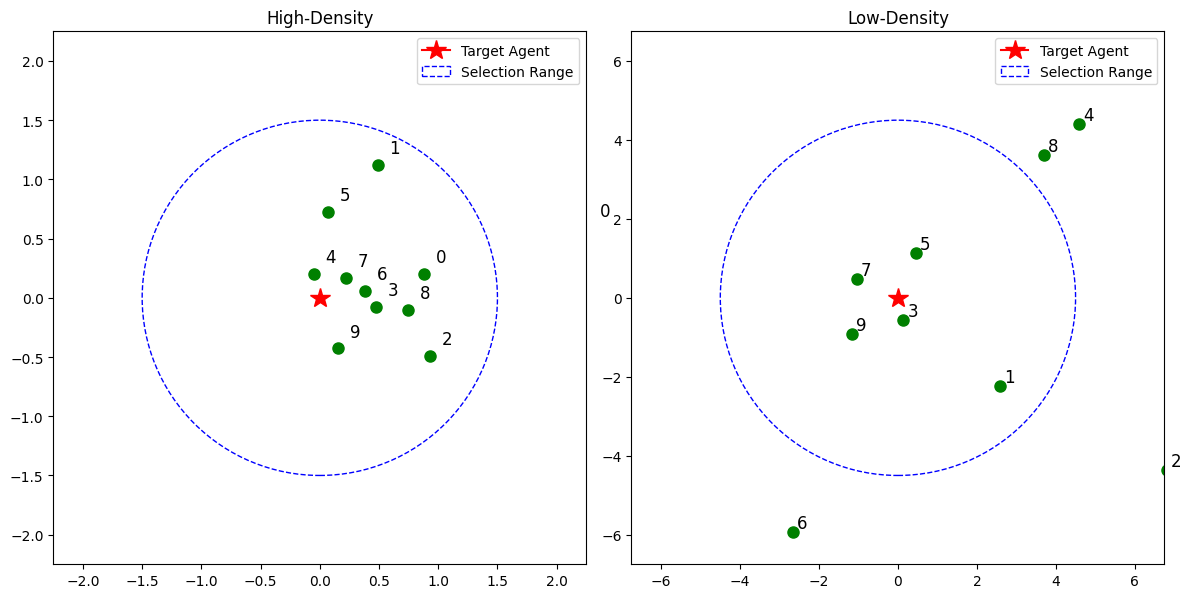

In [ ]:
# Visualization of Density Scenes

def plot_density_scene(sample, title):

    """
    Plots a scene based on the sample to visualize agent positions and neighbor selection.

    Args:
    sample: Dictionary containing agent features and spatial relationships.
    title: Title of the plot (e.g., "High-Density Scene", "Low-Density Scene").

    Visualization Details:
    - The **target agent** (first valid agent) is displayed as a **red star**.
    - A **blue dashed circle** represents the **selection range** for neighbors.
    - Each **neighboring agent** is shown as a **green circle**, with agent IDs labeled.
    """

    # Convert tensor to numpy array
    agent_feats = sample["agent_features"].cpu().numpy()  # shape

    # Only consider rows that are not all zeros
    valid_indices = np.where(np.any(agent_feats != 0, axis=1))[0]
    if len(valid_indices) == 0:
        print("No valid agents in this sample.")
        return
    valid_feats = agent_feats[valid_indices]
    positions = valid_feats[:, :2]  # x and y positions

    # Choose the first valid agent as the target
    target = positions[0]

    # Compute Euclidean distances from the target to all other valid agents
    distances = np.linalg.norm(positions - target, axis=1)

    if len(distances) > 1:
        selection_radius = 1.2 * np.max(distances[1:])
    else:
        selection_radius = 1.0

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the target agent
    ax.plot(target[0], target[1], marker='*', markersize=15, color='red', label='Target Agent')

    # Draw a circle for the neighbor selection range
    circle = plt.Circle((target[0], target[1]), selection_radius, color='blue', fill=False, linestyle='--', label='Selection Range')
    ax.add_artist(circle)

    # Plot and label each agent
    for idx, pos in zip(valid_indices, positions):
        ax.plot(pos[0], pos[1], marker='o', markersize=8, color='green')
        ax.text(pos[0] + 0.1, pos[1] + 0.1, f'{idx}', fontsize=10, color='black')
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# Simulation of Density Changes
def simulate_density(sample, scale_factor):

    new_sample = {}

    for key in sample:

        # For tensor data, apply transformation only on agent_features (which hold positions in the first two dims)
        if key == "agent_features":
            feats = sample[key].clone().cpu().numpy()

            # Multiply only the first two columns (x,y)
            feats[:, :2] = feats[:, :2] * scale_factor
            new_sample[key] = torch.tensor(feats, dtype=torch.float32)
        else:

            new_sample[key] = sample[key]
    return new_sample


# Reproducing Figure 1 (High vs Low Density)
def reproduce_figure1(test_dataset):

    sample = test_dataset[0]  

    # Simulate a high-density scene: scale positions down 
    sample_high = simulate_density(sample, scale_factor=0.5)

    # Simulate a low-density scene: scale positions up 
    sample_low = simulate_density(sample, scale_factor=2.0)

    # Plot both scenes side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    # Plot high-density scene
    agent_feats = sample_high["agent_features"].cpu().numpy()
    valid_indices = np.where(np.any(agent_feats != 0, axis=1))[0]
    positions = agent_feats[valid_indices, :2]
    target = positions[0]
    distances = np.linalg.norm(positions - target, axis=1)
    selection_radius = 1.2 * np.max(distances[1:]) if len(distances) > 1 else 1.0
    axs[0].plot(target[0], target[1], marker='*', markersize=15, color='red', label='Target Agent')
    circle = plt.Circle((target[0], target[1]), selection_radius, color='blue', fill=False, linestyle='--', label='Selection Range')
    axs[0].add_artist(circle)
    for idx, pos in zip(valid_indices, positions):
        axs[0].plot(pos[0], pos[1], marker='o', markersize=8, color='green')
        axs[0].text(pos[0] + 0.1, pos[1] + 0.1, f'{idx}', fontsize=10, color='black')
    axs[0].set_title("High-Density Scene")
    axs[0].set_aspect('equal')

    # Plot low-density scene
    agent_feats = sample_low["agent_features"].cpu().numpy()
    valid_indices = np.where(np.any(agent_feats != 0, axis=1))[0]
    positions = agent_feats[valid_indices, :2]
    target = positions[0]
    distances = np.linalg.norm(positions - target, axis=1)
    selection_radius = 1.2 * np.max(distances[1:]) if len(distances) > 1 else 1.0
    axs[1].plot(target[0], target[1], marker='*', markersize=15, color='red', label='Target Agent')
    circle = plt.Circle((target[0], target[1]), selection_radius, color='blue', fill=False, linestyle='--', label='Selection Range')
    axs[1].add_artist(circle)
    for idx, pos in zip(valid_indices, positions):
        axs[1].plot(pos[0], pos[1], marker='o', markersize=8, color='green')
        axs[1].text(pos[0] + 0.1, pos[1] + 0.1, f'{idx}', fontsize=10, color='black')
    axs[1].set_title("Low-Density Scene")
    axs[1].set_aspect('equal')

    # Final layout settings
    for ax in axs:
        ax.legend()
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
    plt.tight_layout()
    plt.show()


# Running the Reproduction
# Example main function to load a sample and reproduce Figure 1(from Density-Adaptive Model Based on Motif Matrix for Multi-Agent Trajectory Prediction Paper).

def main():

    test_dir = "/content/drive/MyDrive/ColabNotebooks/Argoverse/test/data"
    test_dataset = ArgoverseCSVDataset(
        data_dir=test_dir,
        max_agents=10,
        history_steps=10,
        future_steps=6,
        temporal_T=5,
        dist_threshold=10.0,
        stride=None
    )

    # Reproduce Figure 1 (High vs Low Density)
    reproduce_figure1(test_dataset)

# Run script
if __name__ == "__main__":
    main()


---------

***Zahra Amanli..***